In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
%matplotlib inline
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
# import lightgbm as lgb
# from catboost import CatBoostClassifier, Pool
# from catboost.utils import eval_metric
from sklearn.metrics import roc_auc_score
import os
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, zscore
from statsmodels.stats.weightstats import ztest
from scipy.stats import chi2_contingency

In [5]:
df = pd.read_csv('Dataset/complete_dataset.csv')

In [6]:
print(df)

              id  CustomerId         Surname  CreditScore Geography  Gender  \
0            0.0  15674932.0  Okwudilichukwu        668.0    France    Male   
1            1.0  15749177.0   Okwudiliolisa        627.0    France    Male   
2            2.0  15694510.0           Hsueh        678.0    France    Male   
3            3.0  15741417.0             Kao        581.0    France    Male   
4            4.0  15766172.0       Chiemenam        716.0     Spain    Male   
...          ...         ...             ...          ...       ...     ...   
302558   98021.0  15656096.0           Ch'in        516.0    France    Male   
302559  243523.0  15581323.0           White        536.0    France    Male   
302560  193768.0  15589948.0          Disher        579.0     Spain    Male   
302561  119381.0  15626141.0        Mazzanti        753.0    France    Male   
302562  218536.0  15625021.0            Hung        724.0    France  Female   

         Age  Tenure    Balance  NumOfProducts  Has

In [7]:
print(df.isnull().sum().sum())

9632


In [8]:
print(df.duplicated().sum())

27505


In [9]:
df = df.drop_duplicates()

In [10]:
def fill_missing_values(df):
    
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        if col in ["Exited", "NumOfProducts", "HasCrCard", "IsActiveMember"]:
            continue
        df[col].fillna(df[col].mean(), inplace=True)
    for col in df.select_dtypes(include=['object']).columns:
        df[col].fillna(df[col].mode()[0], inplace=True)
    for col in ["Exited", "NumOfProducts", "HasCrCard", "IsActiveMember"]:
        df[col].fillna(df[col].mode()[0], inplace=True)
    return df
            
fill_missing_values(df)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0.0,1.567493e+07,Okwudilichukwu,668.000000,France,Male,33.000000,3.000000,0.00000,2.0,1.0,0.0,181449.970000,0.0
1,1.0,1.574918e+07,Okwudiliolisa,627.000000,France,Male,33.000000,1.000000,0.00000,2.0,1.0,1.0,49503.500000,0.0
2,2.0,1.569451e+07,Hsueh,678.000000,France,Male,40.000000,10.000000,0.00000,2.0,1.0,0.0,184866.690000,0.0
3,3.0,1.574142e+07,Kao,581.000000,France,Male,34.000000,2.000000,148882.54000,1.0,1.0,1.0,84560.880000,0.0
4,4.0,1.576617e+07,Chiemenam,716.000000,Spain,Male,33.000000,5.000000,0.00000,2.0,1.0,1.0,15068.830000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275053,275053.0,1.577413e+07,Cox,575.000000,France,Female,36.000000,4.000000,178032.53000,1.0,1.0,1.0,42181.680000,0.0
275054,275054.0,1.572846e+07,Ch'iu,712.000000,France,Male,31.000000,2.000000,0.00000,2.0,1.0,0.0,16287.380000,0.0
275055,275055.0,1.568754e+07,Yegorova,709.000000,France,Female,32.000000,3.000000,0.00000,1.0,1.0,1.0,158816.580000,0.0
275056,275056.0,1.566394e+07,Tuan,621.000000,France,Female,37.000000,7.000000,87848.39000,1.0,1.0,0.0,24210.560000,0.0


In [11]:
print(df.isnull().sum().sum())

0


In [12]:
print(df.duplicated().sum())

0


In [13]:
num_col = df.select_dtypes(include=['number']).columns
print(num_col)

Index(['id', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')


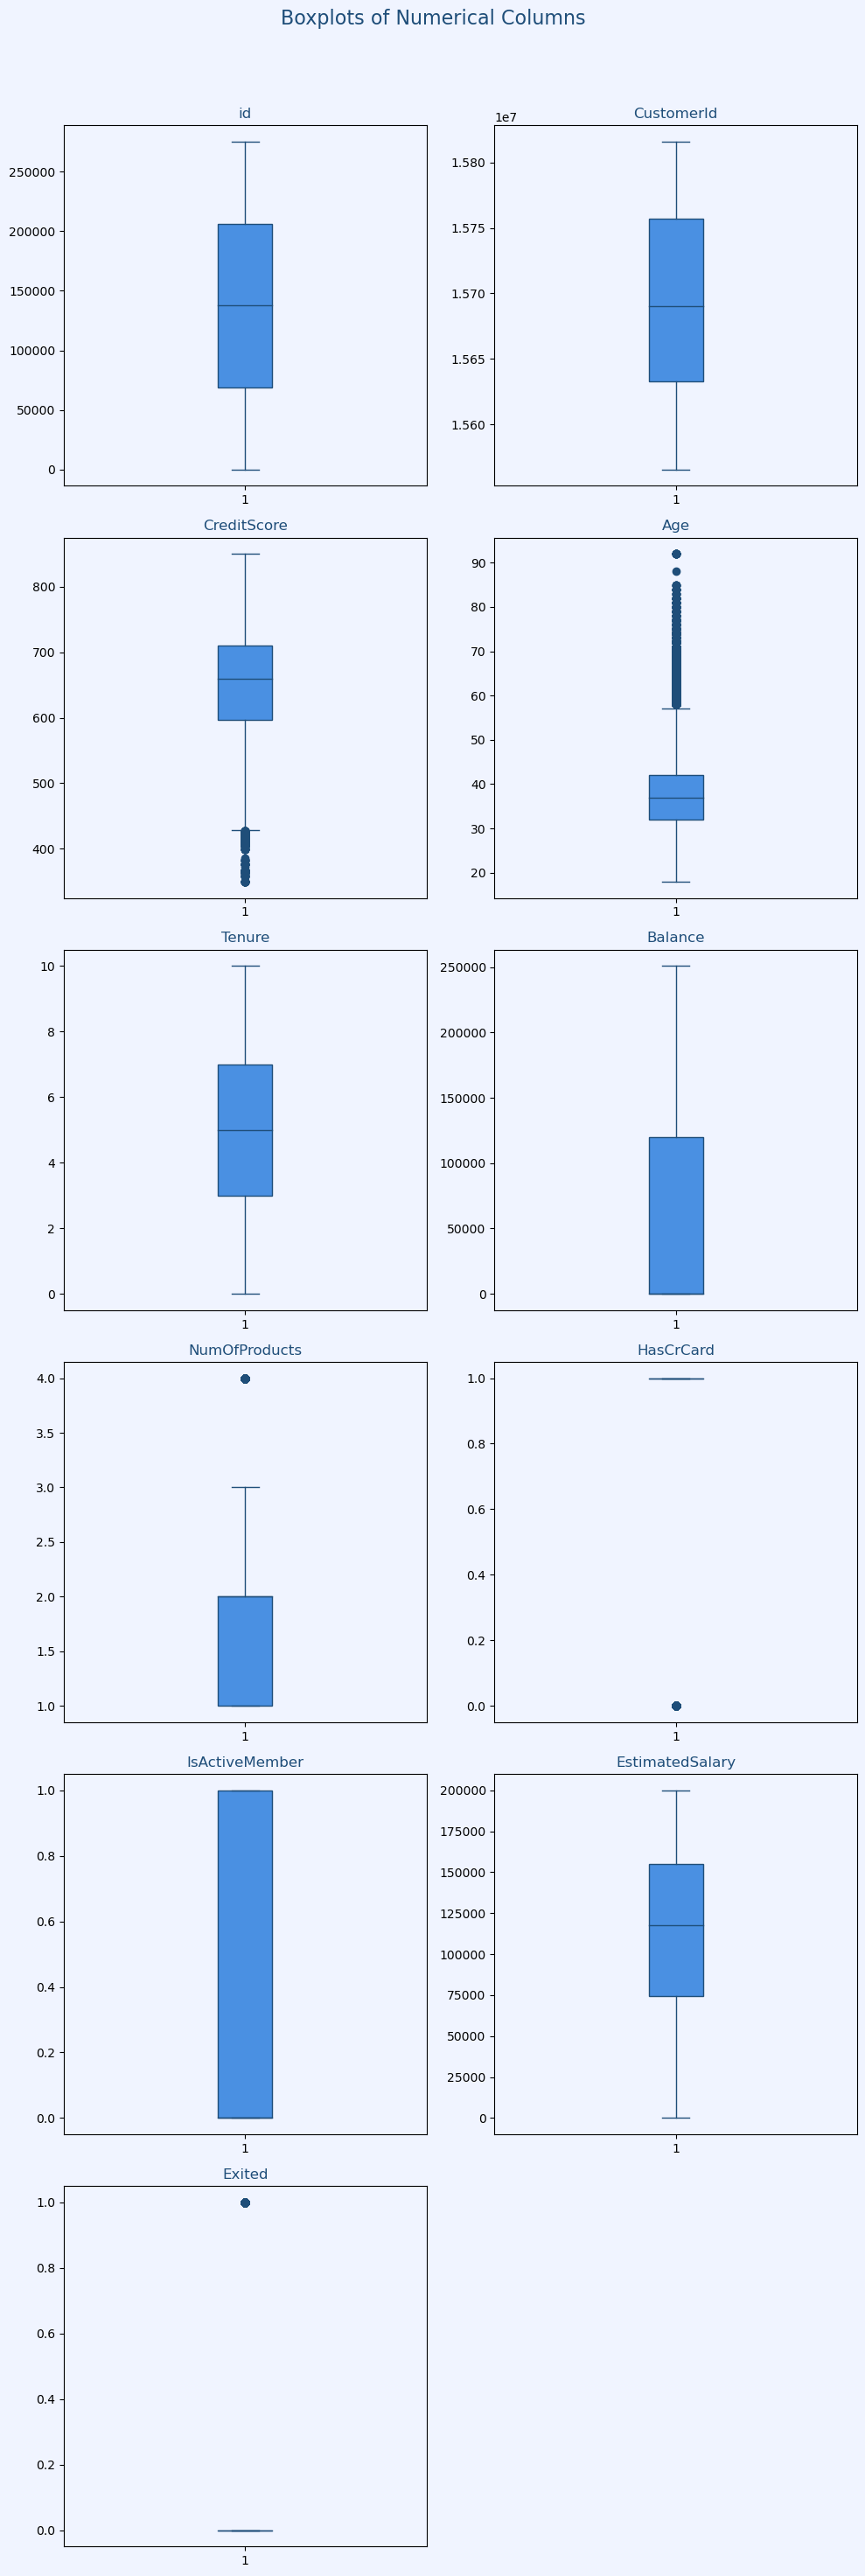

In [14]:
num_col = df.select_dtypes(include=['number']).columns
num_plots = len(num_col)
cols = 2
rows = (num_plots // cols) + (num_plots % cols > 0)

# Set up the figure and axes
fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
fig.suptitle("Boxplots of Numerical Columns", fontsize=16, color="#1f4e79")
fig.patch.set_facecolor('#f0f4ff')  # Light blue background for the entire figure

# Plot each numerical column in a subplot
for i, col in enumerate(num_col):
    ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
    ax.boxplot(df[col].dropna(), patch_artist=True,
               boxprops=dict(facecolor='#4a90e2', color='#1f4e79'),
               whiskerprops=dict(color='#1f4e79'),
               capprops=dict(color='#1f4e79'),
               medianprops=dict(color='#1f4e79'),
               flierprops=dict(markerfacecolor='#1f4e79', markeredgecolor='#1f4e79'))
    ax.set_title(col, color="#1f4e79")
    ax.set_facecolor('#f0f4ff')  # Light blue background for individual plots

# Remove any unused subplots
if num_plots % cols != 0:
    for j in range(num_plots, rows * cols):
        fig.delaxes(axes.flatten()[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

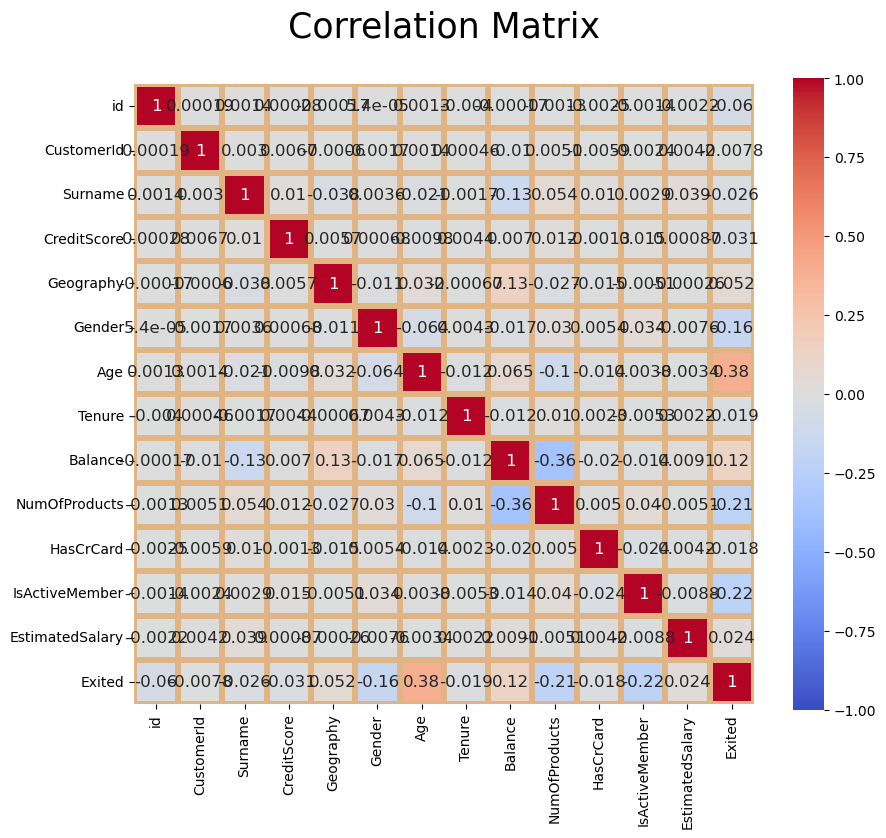

In [15]:

df_corr = df.copy()

catcol = [col for col in df_corr.columns if df_corr[col].dtype == "object"]
le = LabelEncoder()
for col in catcol:
    df_corr[col] = le.fit_transform(df_corr[col])

plt.subplots(figsize=(10, 10))

sns.heatmap(
    df_corr.corr(), 
    cmap="coolwarm", 
    square=True, 
    cbar_kws=dict(shrink=0.82),
    annot=True, 
    vmin=-1, 
    vmax=1, 
    linewidths=3, 
    linecolor='#e0b583', 
    annot_kws=dict(fontsize=12)
)
plt.title("Correlation Matrix\n", fontsize=25)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

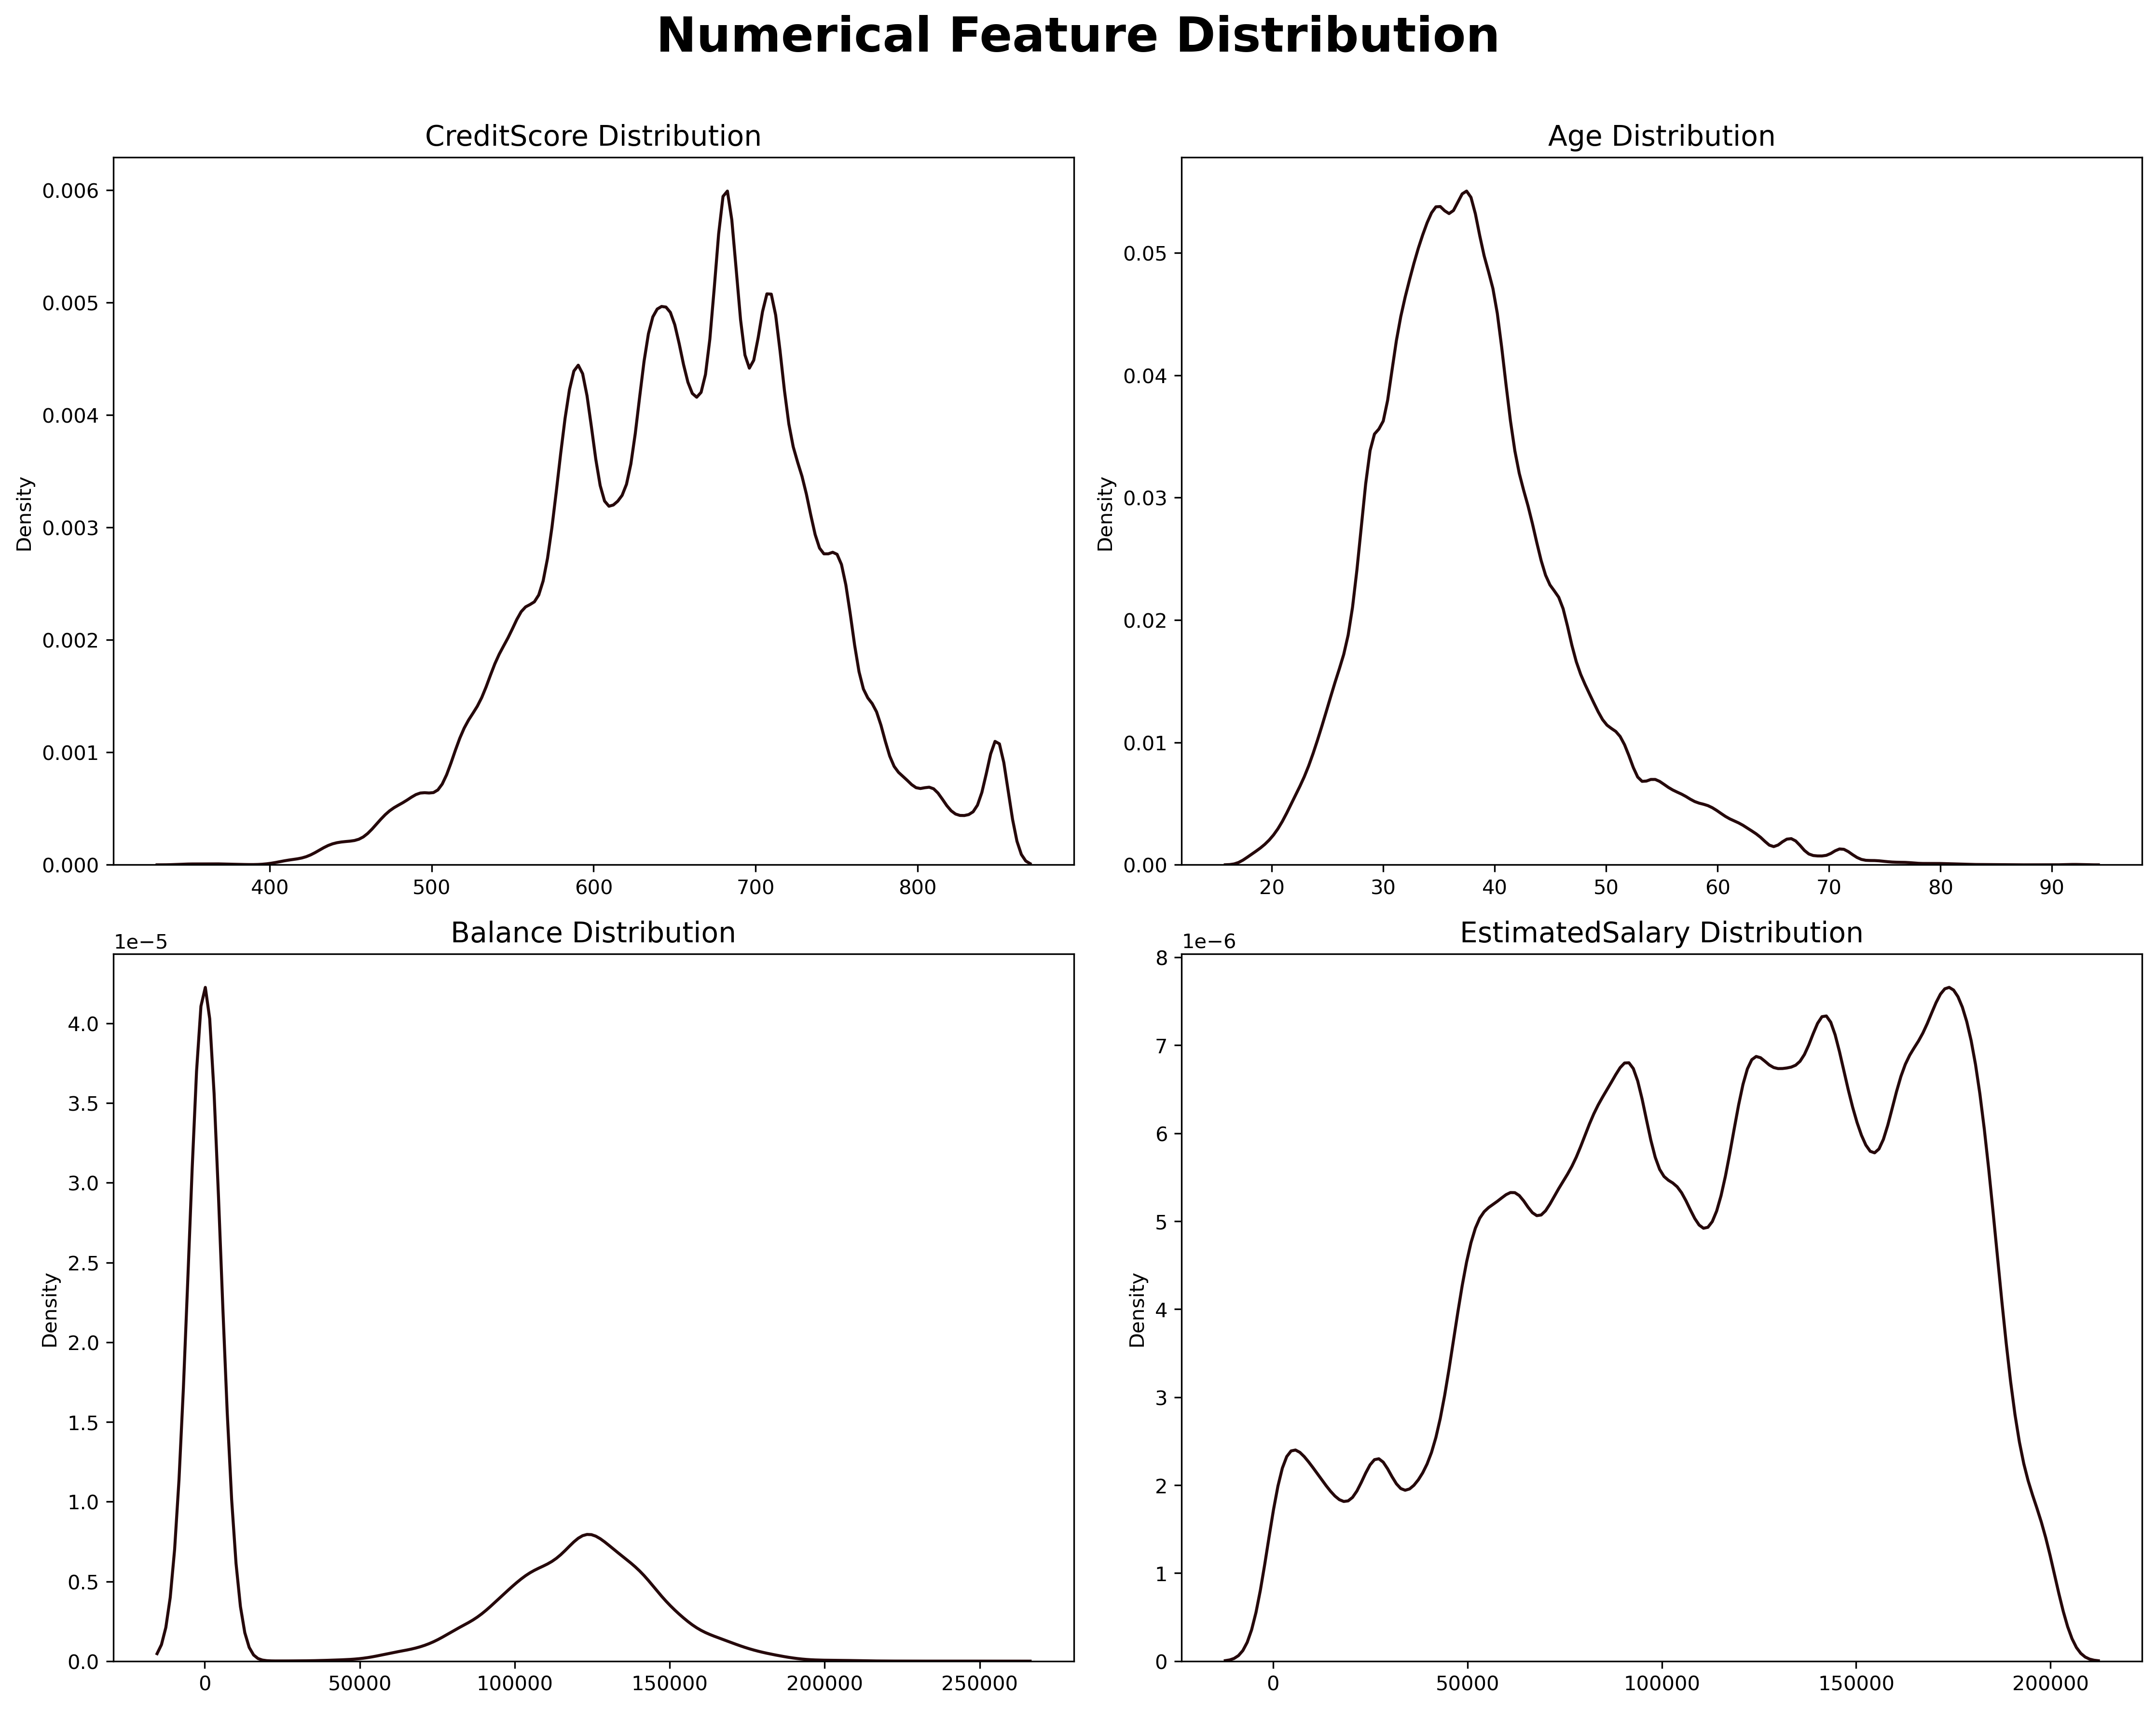

In [16]:
palette = sns.color_palette("coolwarm", n_colors=2)

fig, ax = plt.subplots(2, 2, figsize=(15, 12), dpi=300)
ax = ax.flatten()

numerical_variables = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
for i, column in enumerate(numerical_variables):
    sns.kdeplot(df[column], ax=ax[i], color='#26090b')        
    ax[i].set_title(f'{column} Distribution', size=14)
    ax[i].set_xlabel(None)
    
fig.suptitle('Numerical Feature Distribution\n', fontsize=24, fontweight='bold')
plt.tight_layout()
plt.show()